# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
!pip install anndata lightgbm

  Using cached anndata-0.10.7-py3-none-any.whl.metadata (6.6 kB)
  Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
  Using cached array_api_compat-1.7.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached h5py-3.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
Using cached anndata-0.10.7-py3-none-any.whl (122 kB)
Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)
Using cached array_api_compat-1.7.1-py3-none-any.whl (37 kB)
Using cached h5py-3.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.3 MB)
Using cached natsort-8.4.0-py3-none-any.whl (38 kB)


In [ ]:
!conda install -c conda-forge graph-tool -y 

In [14]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, LeaveOneGroupOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import scipy
import json
# import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import csr_matrix
import lightgbm

%matplotlib inline

work_dir = '../output'
os.makedirs(f'{work_dir}', exist_ok=True)

In [2]:
surragate_names = {'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
                   'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
                   'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'GRANIE': 'GRANIE', 'granie':'GRANIE',
                   'ANANSE': 'ANANSE', 'ananse':'ANANSE',
                   'scGLUE': 'scGLUE', 'scglue':'scGLUE',
                   'HKG': 'HKG', 'HKGs':'HKG',
                   'positive_control':'Positive Control',
                   'negative_control':'Negative Control',
                   'pearson':'Pearson',
                   'SL':'SLA'
                   }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#96b577',
    'CellOracle': '#b0b595',
    'GRANIE': '#c9b4b1',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#e5b8dc',
    'Scenic+': '#dfc2e5',
    'HKG': '#e7d2ec',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}

LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
}

In [3]:
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


# Topological analysis 

In [4]:
grn_model_names = ['collectRI', 'figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [5]:
def dict_2_array(x):
    return np.array(list(x.values()))
def plot_CDF(data, title, ax):
    # Step 3: Sort the Data
    sorted_data = np.sort(data)
    # Step 4: Compute the Cumulative Density
    cumulative_density = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    # Step 5: Plot the Cumulative Density
    ax.scatter(sorted_data, cumulative_density, s=5, marker='o', alpha=.5)  # s is the size of the markers
    ax.set_xlabel('Values')
    ax.set_ylabel('Cumulative Density')
    ax.set_title(title)
    # ax.grid(True)
def plot_bar(data_dict, title=''):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar(data_dict.keys(), data_dict.values())

    ax.set_xlabel('Methods')
    ax.set_ylabel('Values')
    ax.grid(True, axis='y')  # Add grid only on the y-axis for better readability
    ax.set_title(title)
    aa = plt.xticks(rotation=45)

import sys
sys.path.insert(0, f'./')
from computeSTREAMLINE import average_shortest_path

ImportError: /root/anaconda3/envs/py10/lib/python3.10/site-packages/torch/lib/libgomp-a34b3233.so.1: version `GOMP_5.0' not found (required by /root/anaconda3/envs/py10/lib/python3.10/site-packages/graph_tool/libgraph_tool_core.so)

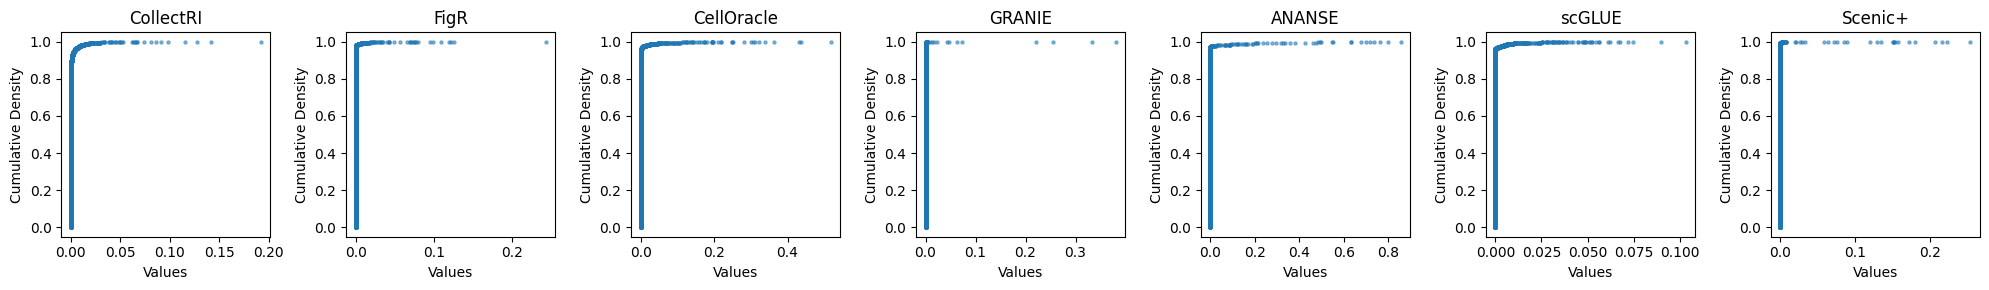

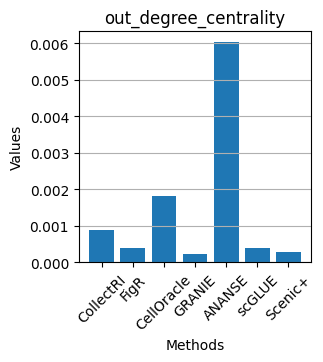

In [22]:
import networkx as nx
fig, axes = plt.subplots(1, 7, figsize=(20, 3))
mean_values = {}
for i_plot, (name, net) in enumerate(grn_models_dict.items()):
    ax = axes[i_plot]
    G  = nx.from_pandas_edgelist(net, source='source', target='target', create_using=nx.DiGraph())
    values = dict_2_array(nx.out_degree_centrality(G))
    plot_CDF(values, name, ax)
    mean_values[name] = np.mean(values)
plt.tight_layout()

plot_bar(mean_values, 'out_degree_centrality')


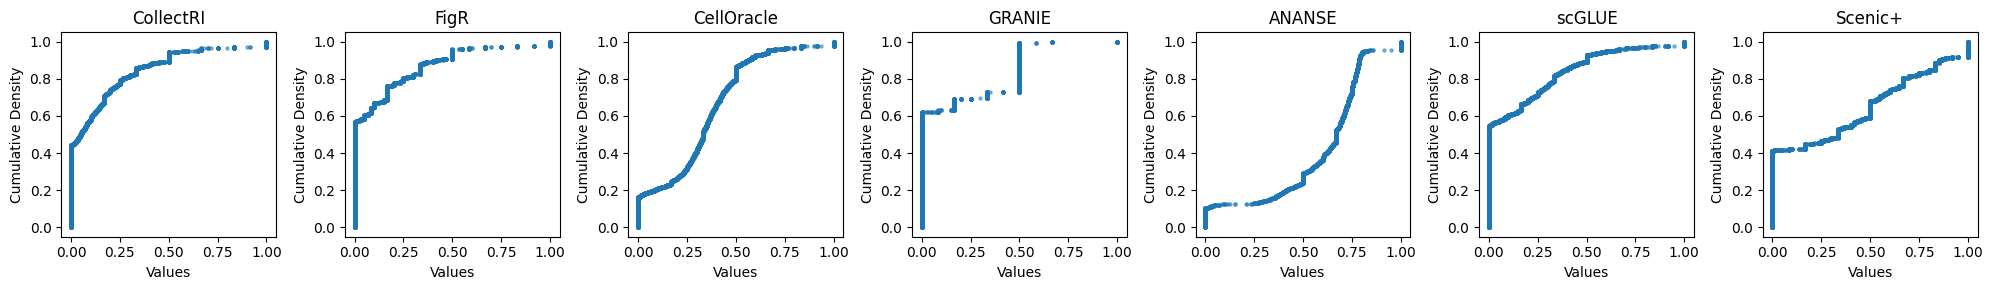

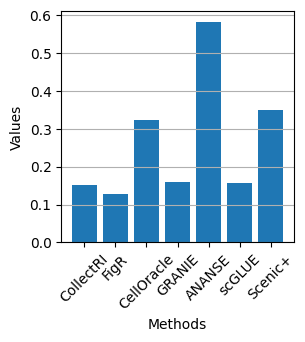

In [24]:
import networkx as nx
fig, axes = plt.subplots(1, 7, figsize=(20, 3))
mean_values = {}
for i_plot, (name, net) in enumerate(grn_models_dict.items()):
    ax = axes[i_plot]
    G  = nx.from_pandas_edgelist(net, source='source', target='target', create_using=nx.DiGraph())

    values = dict_2_array(nx.clustering(G, weight='weight'))
    plot_CDF(values, name, ax)
    mean_values[name] = np.mean(values)
plt.tight_layout()

plot_bar(mean_values, '')

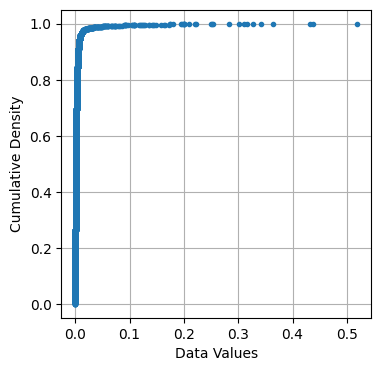

In [41]:

# aa = plt.hist(dict_2_array(nx.degree_centrality(G)), bins=100)


### Regulatory links

In [3]:
links_n = {}
for name, grn in grn_models_dict.items():
    if 'cell_type' in grn.columns: # for cell specific grn models, take the mean
        n_grn = grn.groupby('cell_type').size().mean()
    else:
        n_grn = len(grn)
    links_n[name] = n_grn
print(links_n)

{'FigR': 24292, 'CellOracle': 50000.0, 'GRANIE': 10679, 'ANANSE': 50000, 'scGLUE': 51567, 'Scenic+': 33537}


### Regulatory effect

In [4]:
regulatory_effect_dict = {}
for name, grn in grn_models_dict.items():
    print('-----', name)
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    if 'cell_type' in grn.columns:
        celltype_counts = grn_sign.groupby('cell_type').weight.value_counts()
        signs = [celltype_counts[celltype_counts.index.get_level_values('weight')==1].mean(), celltype_counts[celltype_counts.index.get_level_values('weight')==-1].mean()]
    else:
        signs = grn_sign.weight.value_counts().values # 'positive, negative:
    if len(signs)==1:
        signs = [signs[0], 0]
    regulatory_effect_dict[name] = signs
regulatory_effect_dict

----- FigR
----- CellOracle
----- GRANIE
----- ANANSE
----- scGLUE
----- Scenic+


{'FigR': array([13952, 10340], dtype=int64),
 'CellOracle': [31621.25, 18378.75],
 'GRANIE': array([9340, 1339], dtype=int64),
 'ANANSE': [50000, 0],
 'scGLUE': [51567, 0],
 'Scenic+': array([33102,   435], dtype=int64)}

### TFs and target genes

In [5]:
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()

In [6]:
print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

number of TFs
{'FigR': 389, 'CellOracle': 549, 'GRANIE': 180, 'ANANSE': 77, 'scGLUE': 439, 'Scenic+': 140}
number of targets


{'FigR': 7804,
 'CellOracle': 8597,
 'GRANIE': 6548,
 'ANANSE': 2859,
 'scGLUE': 11450,
 'Scenic+': 10789}

### DORCS

In [9]:
peak_gene_model = ['figr', 'celloracle', 'granie']

CRE_target_df_dict = {}
for name in peak_gene_model:
    model = pd.read_csv(f'../output/benchmark/peak_gene_models/{name}.csv', index_col=0)
    model.peak = model.peak.str.replace('_','-')
    model.peak = model.peak.str.replace(':','-')
    CRE_target_df_dict[name] = model

In [10]:
CRE_target_df_dict = {surragate_names[name]:grn for name, grn in CRE_target_df_dict.items()}

In [11]:
peaks_dict = {}
peaks_n_dict = {}
for name, df in CRE_target_df_dict.items():
    peaks_dict[name] = df.peak.unique()
    peaks_n_dict[name] = df.peak.unique().shape[0]

In [12]:
# multiple thresholds 
dorcs_n_dict = {}
thresholds_dorcs = range(5, 20)
for name, df in CRE_target_df_dict.items():
    stack_ = []
    for t in thresholds_dorcs:
        stack_.append((df.groupby('target').size()>=t).sum())
    dorcs_n_dict[name] = stack_

### Master TFs

In [13]:
# range of thresholds 
thresholds_master_TFs = range(100, 5000, 10)
master_tfs_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_master_TFs:
        size_ = grn.groupby('source').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    master_tfs_n_dict[name] = stack_

### In-degree for target genes

In [14]:
thresholds_indegree = range(5,20,1)
indegree_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_indegree:
        size_ = grn.groupby('target').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    indegree_n_dict[name] = stack_

### Plot number of GRN elements 

C:\Users\antoi\AppData\Local\Temp\ipykernel_14716\225772886.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


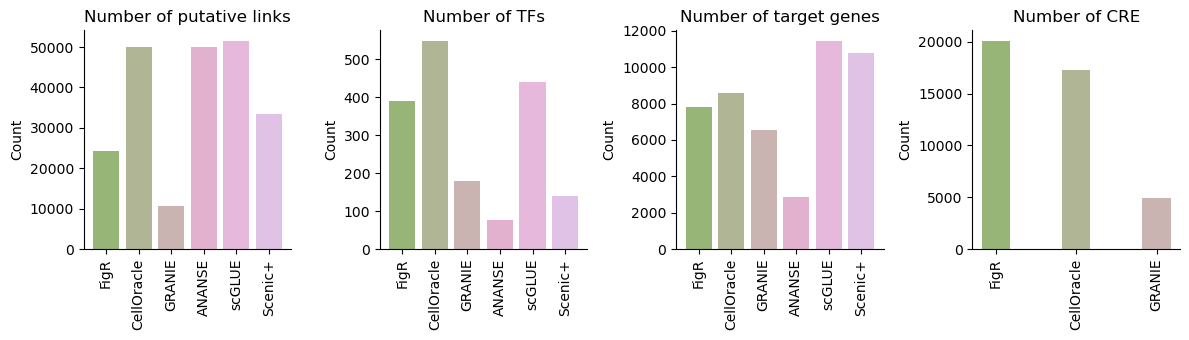

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3.5)) 
color = 'grey'
## number of links
ax = axes[0]
colors = [COLORS[surragate_names[name]] for name in links_n.keys()]
ax.bar(links_n.keys(), links_n.values(), color=colors)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of putative links')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[1]
ax.bar(tfs_dict_n.keys(), tfs_dict_n.values(), color=colors)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of TFs')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
## number of target 
ax = axes[2]

ax.bar(target_genes_dict_n.keys(), target_genes_dict_n.values(), color=colors)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of target genes')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

## number of peaks 
ax = axes[3]
colors = [COLORS[surragate_names[name]] for name in links_n.keys()]
ax.bar(peaks_n_dict.keys(), peaks_n_dict.values(), color=colors, width=0.35)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of CRE')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/stats_regulatory_elements.png', dpi=150, transparent=True)

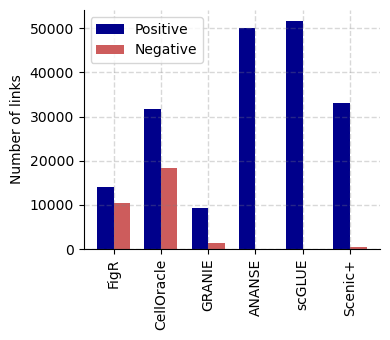

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5)) 
# regulatory role 
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive', color=COLORS['Positive'])
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative', color=COLORS['Negative'])
ax.set_ylabel('Number of links')
# ax.set_title('Regulatory sign')
ax.set_xticks(x)
ax.set_xticklabels(categories)
# ax.set_xticklabels([category for category in categories])
ax.tick_params(axis='x', rotation=90)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.3, linestyle='--', linewidth=1, color='grey')
# ax.set_yscale('log')
ax.legend()
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/regulatory_signs.png', dpi=150, transparent=True)

### Plot intersection of GRN elements
venn diagram

In [43]:
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link'].drop_duplicates().reset_index(drop=True)

### upsetplot of GRN elements

 ####### Links
 ####### target genes
 ####### TFs
 ####### CRE


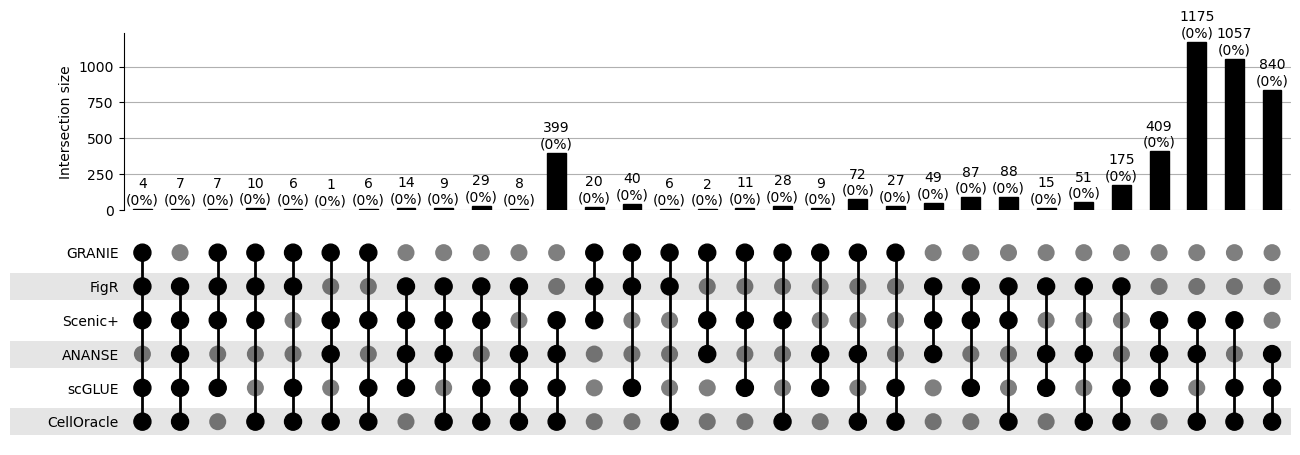

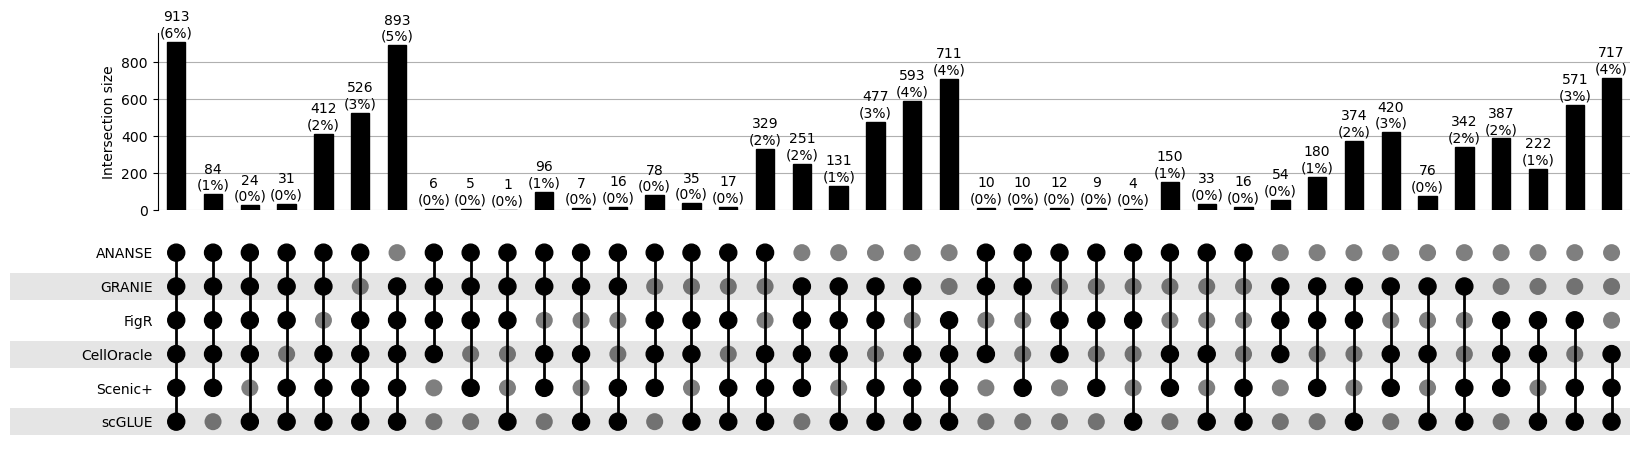

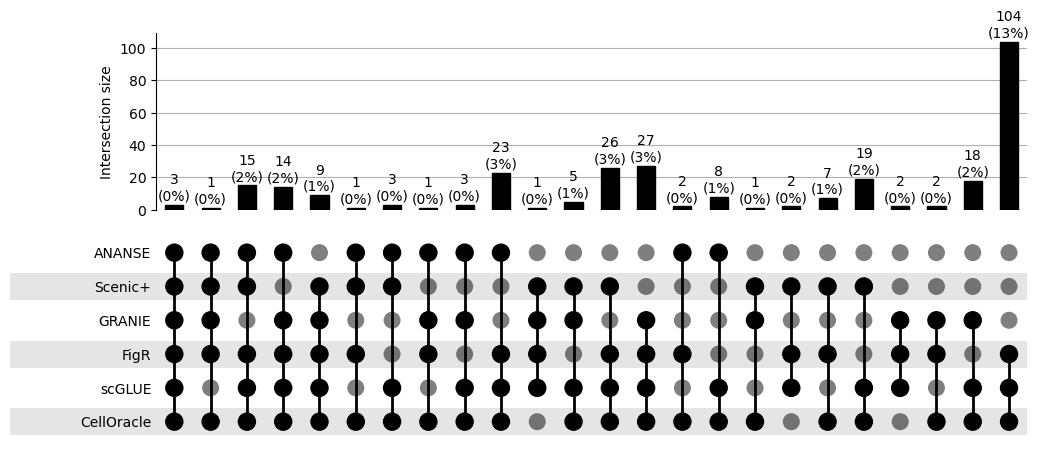

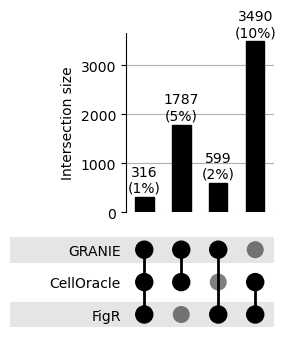

In [44]:
from upsetplot import from_indicators, plot
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")
# Create a set of all unique genes
def convert_df(data):
    all_genes = list(set(gene for genes in data.values() for gene in genes))
    # Initialize DataFrame
    df = pd.DataFrame(index=all_genes)
    # Populate DataFrame
    for key, genes in data.items():
        df[key] = df.index.isin(genes)
    return df


print(' ####### Links')
fig = plt.figure()
df_interactions = convert_df(grn_fused_dict)    
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions),fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35, #side length
        intersection_plot_elements=5,
        totals_plot_elements = 0)
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/links_interactions.png', dpi=150, transparent=True)

print(' ####### target genes')
fig = plt.figure()
df_interactions = convert_df(target_genes_dict)    
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0)
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/targets_interactions.png', dpi=150, transparent=True)


print(' ####### TFs')
fig = plt.figure()
df_interactions = convert_df(tfs_dict)
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0
        )
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/TFs_interactions.png', dpi=150, transparent=True)

print(' ####### CRE')
fig = plt.figure()
df_interactions = convert_df(peaks_dict)
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree',  #-cardinality
        # min_subset_size =100, 
        min_degree=2,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0
        )
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
#     fig.savefig(f'{work_dir}/benchmark/figs/CRE_interactions.png', dpi=150, transparent=True)

### Plot connectivity (DORCs, master TFs, etc)

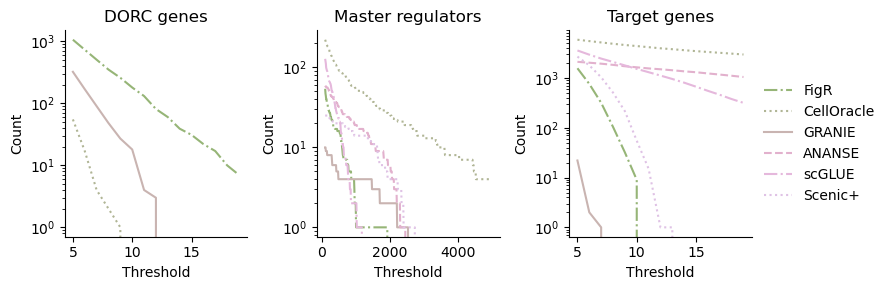

In [161]:
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

fig, axes = plt.subplots(1, 3, figsize=(9, 3)) 
def plot_lines(ax, data, x_range, title):
    for i, key in enumerate(data):
        ax.plot(x_range, data[key], label=key, color=COLORS[surragate_names[key]], linestyle=LINESTYLES[key])
        # ax.plot(x_range, data[key], label=key, color=colors_light[i])
    # ax.set_xticks(x_range)
    # ax.set_xticklabels(thresholds_indegree)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_yscale('log')
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    
## DORCs
plot_lines(axes[0], dorcs_n_dict, thresholds_dorcs, 'DORC genes')

## master TFs
plot_lines(axes[1], master_tfs_n_dict, thresholds_master_TFs, 'Master regulators')

## in degree for target genes 
plot_lines(axes[2], indegree_n_dict, thresholds_indegree, 'Target genes')

axes[-1].legend(loc='upper left', bbox_to_anchor=(1,.8), frameon=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/connectivity.png', dpi=150, transparent=True)

## Types of peaks

In [51]:
%load_ext rpy2.ipython

C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [52]:
temp_dir = f'{work_dir}/benchmark/temp/peak_annotation/'
os.makedirs(temp_dir)
for name, grn_ct in CRE_target_df_dict.items():
    peaks = grn_ct.peak.str.split('-', n=1, expand=True)
    peaks.columns = ['chr','range']
    peaks.to_csv(f'{temp_dir}{name}.txt', index=False)
method_names = list(CRE_target_df_dict.keys())

In [56]:
%%R -i method_names -i temp_dir
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

install.packages("IRanges")
install.packages("GenomicRanges")
install.packages("ggplot2")
install.packages("TxDb.Hsapiens.UCSC.hg38.knownGene")

library(IRanges)
library(GenomicRanges)
library(ggplot2)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

for (name in method_names){
  peaks = read.table(paste0(temp_dir, name, '.txt'), sep=',', header = TRUE)
  peaks = GRanges(peaks$chr, IRanges(peaks$range))
  peaks_annotated = suppressMessages(ChIPseeker::annotatePeak(
      peaks,
      tssRegion = c(-1000, 1000), # extended from -5kb to 5
      TxDb = txdb,
      level = "transcript", 
      assignGenomicAnnotation = TRUE,  # the default
      genomicAnnotationPriority = c("Promoter", "5UTR", "3UTR", "Exon", "Intron",
                                    "Downstream", "Intergenic"),  # the default
      annoDb = NULL,
      sameStrand = FALSE, # the default
      ignoreOverlap = FALSE, # the default
      ignoreUpstream = FALSE, # the default
      ignoreDownstream = FALSE, # the default
      overlap = "TSS", # the default
      verbose = TRUE # the default
    ))
  peaks_annotated_df = as.data.frame(peaks_annotated)
  write.table(peaks_annotated_df, paste0(temp_dir, name, '_annot.txt'), sep=',', row.names = FALSE)
}


Exception ignored from cffi callback <function _consolewrite_ex at 0x00000239312BB880>:
Traceback (most recent call last):
  File "C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 71: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000239312BB880>:
Traceback (most recent call last):
  File "C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENC

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000239312BB880>:
Traceback (most recent call last):
  File "C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 75: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000239312BB880>:
Traceback (most recent call last):
  File "C:\Users\antoi\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENC

'utf-8' codec can't decode byte 0xe9 in position 75: invalid continuation byte


RInterpreterError: Failed to parse and evaluate line 'options(digits=5, max.print=100)  # Adjust numbers as needed\nset.seed(123)\n\ninstall.packages("IRanges")\ninstall.packages("GenomicRanges")\ninstall.packages("ggplot2")\ninstall.packages("TxDb.Hsapiens.UCSC.hg38.knownGene")\n\nlibrary(IRanges)\nlibrary(GenomicRanges)\nlibrary(ggplot2)\nlibrary(TxDb.Hsapiens.UCSC.hg38.knownGene)\n\ntxdb <- TxDb.Hsapiens.UCSC.hg38.knownGene\n\nfor (name in method_names){\n  peaks = read.table(paste0(temp_dir, name, \'.txt\'), sep=\',\', header = TRUE)\n  peaks = GRanges(peaks$chr, IRanges(peaks$range))\n  peaks_annotated = suppressMessages(ChIPseeker::annotatePeak(\n      peaks,\n      tssRegion = c(-1000, 1000), # extended from -5kb to 5\n      TxDb = txdb,\n      level = "transcript", \n      assignGenomicAnnotation = TRUE,  # the default\n      genomicAnnotationPriority = c("Promoter", "5UTR", "3UTR", "Exon", "Intron",\n                                    "Downstream", "Intergenic"),  # the default\n      annoDb = NULL,\n      sameStrand = FALSE, # the default\n      ignoreOverlap = FALSE, # the default\n      ignoreUpstream = FALSE, # the default\n      ignoreDownstream = FALSE, # the default\n      overlap = "TSS", # the default\n      verbose = TRUE # the default\n    ))\n  peaks_annotated_df = as.data.frame(peaks_annotated)\n  write.table(peaks_annotated_df, paste0(temp_dir, name, \'_annot.txt\'), sep=\',\', row.names = FALSE)\n}\n'.
R error message: "'utf-8' codec can't decode byte 0xe9 in position 75: invalid continuation byte"
R stdout:
Warning:Warning:Warning:In addition: Warning message:

In [62]:
map_={'Intron':'Intron', 'Exon':'Exon', 'Promoter':'Promoter', 'Distal':'Distal Intergenic', "3'":"3' UTR", 'Downstream':'Downstream (<=300)', "5'":"5' UTR"}

annotation_dict = {}
for name in method_names:
    ann_df = pd.read_csv(f'{temp_dir}{name}_annot.txt')
    ann = ann_df.annotation.str.split(' ', expand=True)[0]
    ann = ann.map(map_)
    value_counts = ann.value_counts()
    sum_values = value_counts.sum()
    value_ratio = (value_counts/sum_values)*100
    annotation_dict[name] = value_ratio.to_dict()
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
# peak_annotation_df.index = peak_annotation_df.index.map(surragate_names)
peak_annotation_df

,Intron,Promoter,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
FigR,36.989504,30.980451,18.574342,6.605979,4.457046,1.552007
CellOracle,0.527868,98.782576,0.271067,0.199734,0.085600,0.009511
GRANIE,22.013844,55.891822,12.942692,4.370573,3.187379,1.150998


               Intron   Promoter  Distal Intergenic      Exon    3' UTR  \
FigR        36.989504  30.980451          18.574342  6.605979  4.457046   
CellOracle   0.527868  98.782576           0.271067  0.199734  0.085600   
GRANIE      22.013844  55.891822          12.942692  4.370573  3.187379   

            Downstream (<=300)  
FigR                  1.552007  
CellOracle            0.009511  
GRANIE                1.150998  


C:\Users\antoi\AppData\Local\Temp\ipykernel_14716\148523998.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, len(peak_annotation_df.index) + 1, i + 1)
C:\Users\antoi\AppData\Local\Temp\ipykernel_14716\148523998.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[i] == 0:
C:\Users\antoi\AppData\Local\Temp\ipykernel_14716\148523998.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[i] > 1:
C:\Users\antoi\AppData\Local\Temp\ipykernel_14716\14852399

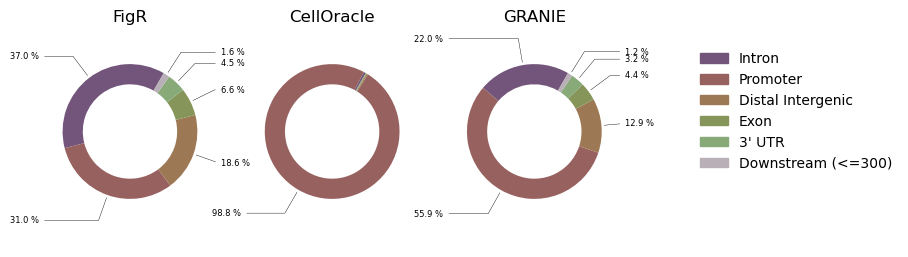

In [104]:
fig, ax = plt.subplots(figsize=(10, 3))
print(peak_annotation_df)
"""
ax = peak_annotation_df.plot(kind='bar', stacked=True, ax=ax, rot=45, xlabel='', ylabel='Ratio (%)', color=colors_light)
for c in ax.containers:
    threshold = 2 # skip below this 
    labels = [int(v.get_height().round(2)) if v.get_height() > threshold else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# ax.set_title('CREs')
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/annot_peaks.png', dpi=150, transparent=True)
"""

colors = ['#73557b', '#97615f', '#9d7854', '#86965a', '#88aa79', '#b9afb7']
startangle=60
for i in range(len(peak_annotation_df.index)):
    ax = plt.subplot(1, len(peak_annotation_df.index) + 1, i + 1)
    ax.set_title(peak_annotation_df.index[i] + '\n')
    counts = peak_annotation_df.iloc[i]
    wedges, texts = ax.pie(counts, colors=colors, wedgeprops=dict(width=0.3), startangle=startangle)
    #ax.pie(sig_counts, colors=sig_colors, wedgeprops=dict(width=0.3), startangle=startangle, radius=0.55)

    bbox_props = dict(fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-", linewidth=0.3), zorder=0, va="center", fontsize=6)

    for i, p in enumerate(wedges):
        if counts[i] == 0:
            continue
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if counts[i] > 1:
            text = f'{counts[i]:.1f} %'
            ax.annotate(text, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, **kw)

ax = plt.subplot(1, len(peak_annotation_df.index) + 1, len(peak_annotation_df.index) + 1)
patches = []
for color, name in zip(colors, peak_annotation_df.columns):
    patches.append(mpatches.Patch(color=color, label=name))
leg = ax.legend(handles=patches, bbox_to_anchor=(1.5, 0.9))
leg.get_frame().set_linewidth(0.0)
ax.axis('off')

#plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/annot_peaks.png', dpi=150, transparent=True)

plt.show()

# HVGs analysis


In [93]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

n_hvgs = 3000

### Highly devient genes: raw counts
Germain et al. instead proposes to use deviance for feature selection which works on raw counts [Germain et al., 2020]. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile across cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the binomial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e., they don’t show constant expression across cells).

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -i work_dir
library(scry)
library(zellkonverter)
library(SingleCellExperiment)
options(digits=5, max.print=100)  # Adjust numbers as needed



adata = readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
sce = devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [94]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

C:\Users\antoi\anaconda3\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


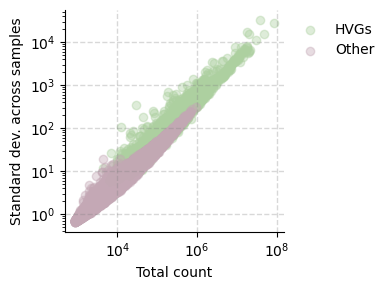

In [116]:
genes = hvgs_sce
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = bulk_adata_f.var
var['sum'] = bulk_adata_f.X.sum(axis=0)
var['std'] = bulk_adata_f.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='#add0a0')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Other', alpha=0.4, color='#c4a8b5')


ax.set_ylabel('Standard dev. across samples')
ax.set_xlabel('Total count')
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(alpha=0.3, linestyle='--', linewidth=1, color='grey')

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

### GRN targets vs HVGs 

In [117]:
genesets_dict = {**{name:grn.target.unique() for name, grn in grn_models_dict.items()}, **{'HKGs':housekeeping_genes}}

In [118]:
hvgs = hvgs_sce

hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {}
n_random = 100
for name, geneset in genesets_dict.items():
    pert_genes = bulk_adata_f.var_names
    shared_genes = np.intersect1d(geneset, pert_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(pert_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
hvgs_intersection_ratio_dict

{'FigR': 0.3111812593454062,
 'CellOracle': 0.30914826498422715,
 'GRANIE': 0.2857142857142857,
 'ANANSE': 0.512273212379936,
 'scGLUE': 0.32481376830208064,
 'Scenic+': 0.2808685319217889,
 'HKGs': 0.19072925893120757}

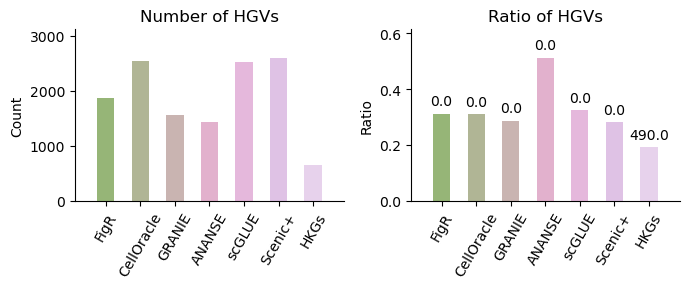

In [137]:
hvgs = hvgs_sce

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)


def plot_bar(ax, data, y_label, title, top_p_dict=None):
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

    colors = [COLORS[surragate_names[key]] for key in data.keys()]
    
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color=colors, label='SCRE')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text] + 0.02, txt, ha='center', va='bottom')


width = .5

plot_bar(axes[0], hvgs_intersection_n_dict, y_label='Count', title='Number of HGVs')
plot_bar(axes[1], hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio of HGVs', top_p_dict=top_p_dict)

# axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)
plt.show()

# GRN Weight-based regression 

In [4]:
norm_method = None

bulk_adata = ad.read('../output/preprocess/bulk_adata_integrated.h5ad')
bulk_index = ['sm_name', 'cell_type', 'donor_id', 'plate_name', 'row']
# data = bulk_adata.layers[f'X_norm_{norm_method}']
# data = bulk_adata.X
data = bulk_adata.layers['seurat']

df_train = pd.DataFrame(data, columns=bulk_adata.var.index, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]))

df_train.head()


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


index                                                            A1BG  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.456954   
                      Myeloid cells Donor 1  010        A   -0.575009   
                      NK cells      Donor 1  010        A   -0.367954   
                      T cells       Donor 1  010        A    0.665574   
MK-5108               B cells       Donor 1  010        A    1.214316   

index                                                        A1BG-AS1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    0.178955   
                      Myeloid cells Donor 1  010        A    0.106276   
                      NK cells      Donor 1  010        A    1.007036   
                      T cells       Donor 1  010        A    0.382907   
MK-5108               B cells       Donor 1  010        A    2.541742   

index                                                             A2M  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.675342   
                      Myeloid cells Donor 1  010        A    1.310987   
                      NK cells      Donor 1  010        A    0.003117   
                      T cells       Donor 1  010        A   -0.564866   
MK-5108               B cells       Donor 1  010        A   -0.675492   

index                                                         A2M-AS1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.672942   
                      Myeloid cells Donor 1  010        A   -0.652688   
                      NK cells      Donor 1  010        A    1.063749   
                      T cells       Donor 1  010        A   -0.452515   
MK-5108               B cells       Donor 1  010        A   -0.668740   

index                                                           A2MP1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.480910   
                      Myeloid cells Donor 1  010        A   -0.480910   
                      NK cells      Donor 1  010        A    1.116476   
                      T cells       Donor 1  010        A   -0.178416   
MK-5108               B cells       Donor 1  010        A   -0.480910   

index                                                            AAAS  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    0.037427   
                      Myeloid cells Donor 1  010        A   -0.674204   
                      NK cells      Donor 1  010        A    0.727295   
                      T cells       Donor 1  010        A   -1.417941   
MK-5108               B cells       Donor 1  010        A   -0.964661   

index                                                            AACS  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    1.854700   
                      Myeloid cells Donor 1  010        A    0.057568   
                      NK cells      Donor 1  010        A   -0.414309   
                      T cells       Donor 1  010        A   -0.381207   
MK-5108               B cells       Donor 1  010        A    0.874025   

index                                                           AAGAB  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.730331   
                      Myeloid cells Donor 1  010        A    1.033481   
                      NK cells      Donor 1  010        A    0.313179   
                      T cells       Donor 1  010   

In [5]:
cell_type_index = df_train.index.get_level_values('cell_type').astype(str) 

In [17]:
# grn_model_names = ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']
grn_model_names = ['celloracle', 'scenicplus']

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

# grn_models_dict = {}
# baselines = ['positive_control', 'negative_control']
baselines = ['positive_control']
for name in baselines:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/baseline_models/{name}.csv', index_col=0)


In [8]:
grn_models_dict.keys()

dict_keys(['positive_control', 'negative_control'])

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
# from skranger.ensemble import RangerForestRegressor
# from sklearn.multioutput import MultiOutputRegressor


class lightgbm_wrapper:
    def __init__(self, params):
        self.params =  params
        
    def fit_predict(self, X_train, Y_train, X_test):
        y_pred_list = []
        for i in range(Y_train.shape[1]):
            regr = 
            regr.fit(X_train, Y_train[:, i])
            y_pred = regr.predict(X_test)
            y_pred_list.append(y_pred)
            
        return np.stack(y_pred_list, axis=1)
    def predict(self)

In [15]:
class Regression_analysis_GRN_weight:
    ''' Uses GRN weights as feature space to predict perturbation data.
    '''
    def __init__(self, 
            **kwargs) -> None:
        self.run_groups(**kwargs)

    def run_groups(self, df_train:pd.DataFrame,
            net: pd.DataFrame, 
            group_index: str, 
            reg_type: str = 'GB', 
            params: dict = {}, 
            verbose: int = 0
            ) -> None:
        cell_type_index = df_train.index.get_level_values('cell_type')

        self.r2_scores_groups = {}
        n_groups = len(group_index.unique())
        pbar = tqdm.tqdm(group_index.unique(), desc="Group cv")
        for group_i, group in enumerate(pbar):
            # subset df for cell type 
            mask = group_index==group
            df_subset = df_train[mask]

            cell_type = df_subset.index.get_level_values('cell_type').unique()[0]

            # net is cell type dependent or not 
            if 'cell_type' in net:
                net_celltype = net[net.cell_type==cell_type]
            else:
                net_celltype = net.copy()
            # match net and df in terms of shared genes
            grn_net = self.match_data(df_train, net_celltype)

            # pivot to have gene*tf matrix
            grn_net = net_celltype.pivot(index='target', columns='source', values='weight').fillna(0)
            if verbose >=2:
                print(f'X (genes, TFs): {grn_net.shape}, Y (genes, samples): {Y.shape}')
            # fill random weights for the missing genes
            grn_net = self.add_random_weights(df_subset, grn_net)
            
            # get training data
            X = grn_net.values
            Y = df_subset.values.T              
            # run cv 
            self.r2_scores_groups[group] = self.run_cross_validation(X, Y, reg_type)
    def get_results(self) -> dict[str, float]:
        return self.r2_scores_groups

    @staticmethod
    def add_random_weights(df_train, net):
        net_genes = net.index.unique()
        shared_genes = np.intersect1d(net_genes, df_train.columns)
        missing_genes = np.setdiff1d(df_train.columns, shared_genes)
        tfs_n = net.columns.unique().shape[0]
        
        sparsity = (net.values==0).sum()/net.values.size
        ratios = [sparsity, (1-sparsity)/2, (1-sparsity)/2]
        shape = (missing_genes.shape[0], tfs_n)
        X_random = np.random.choice([0, -1, 1], size=shape, p=ratios)
        net = pd.concat([net, pd.DataFrame(X_random, columns=net.columns, index=missing_genes)])
        net = net.reindex(df_train.columns)
        return net
    @staticmethod
    def match_data(df_train: pd.DataFrame, net_celltype: pd.DataFrame) -> pd.DataFrame:
        # match net and df in terms of shared genes 
        net_genes = net_celltype.target.unique()
        shared_genes = np.intersect1d(net_genes, df_train.columns)
        net_celltype = net_celltype[net_celltype.target.isin(shared_genes)]

        return net_celltype
    @staticmethod
    def cv_5(genes_n):
        '''5 fold standard'''
        num_groups = 5
        group_size = genes_n // num_groups
        groups = np.repeat(np.arange(num_groups), group_size)
        if genes_n % num_groups != 0:
            groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
        np.random.shuffle(groups)
        return groups
    @classmethod
    def run_cross_validation(cls, X: np.ndarray, Y: np.ndarray, reg_type: str):
        # determine regressor 
        if reg_type=='ridge':
            regr = MultiOutputRegressor(Ridge(**params))
        else:
            regr = MultiOutputRegressor(lightgbm.LGBMRegressor(**params), n_jobs=10)

        # define cv scheme
        cv_groups = cls.cv_5(X.shape[0])

        Y_pred_stack = []
        Y_true_stack = []
        unique_cv_groups = np.unique(cv_groups)
        
        for cv_group in unique_cv_groups:
            mask_va = cv_groups==cv_group
            mask_tr = ~mask_va

            X_tr, Y_tr = X[mask_tr,:], Y[mask_tr,:]
            X_va, Y_true = X[mask_va,:], Y[mask_va,:]

            regr.fit(X_tr, Y_tr)
            Y_pred = regr.predict(X_va)

            Y_pred_stack.append(Y_pred)
            Y_true_stack.append(Y_true)
        y_pred = np.concatenate(Y_pred_stack, axis=0)
        y_true = np.concatenate(Y_true_stack, axis=0)
        r2_score_group = r2_score(y_true, y_pred, multioutput='variance_weighted') #uniform_average', 'variance_weighted
        return r2_score_group


In [19]:
reg_type = 'GB'
manipulate = None #'signed', None 'shuffled'


In [21]:
if True:
    os.makedirs(f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/', exist_ok=True)

    # grn_model = 'celloracle'
    # net = grn_models_dict[grn_model]

    for i_model, (grn_model, net) in enumerate(grn_models_dict.items()):
        print(grn_model)
        print(f'{i_model+1}/{len(grn_models_dict)} in run')
        # shuffle or 
        if manipulate=='shuffled':
            net = grn_shuffle(net)
        elif manipulate=='signed':
            net = sign_grn(net)
        # print(grn_model)
        if reg_type=='ridge':
            params = dict(random_state=32, alpha = 100) 
        elif reg_type=='rf':
            params = dict(random_state=32, n_estimators=100, boosting_type="rf", n_jobs=10, 
            feature_fraction = 0.8, verbosity=-1 )
            # params = dict(seed =32, n_estimators=100)
        elif reg_type=='GB':
            params = dict(random_state=32, n_estimators=100, min_samples_leaf=2, min_child_samples=1, feature_fraction=0.05, verbosity=-1)

        else:
            raise ValueError('define first')
        obj = Regression_analysis_GRN_weight(df_train=df_train, net=net, group_index=cell_type_index, reg_type=reg_type, params=params, verbose=0)
        output = obj.get_results() 
        with open(f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/{grn_model}_{manipulate}.json', 'w') as f:
            json.dump(output, f)


celloracle
1/3 in run


Group cv:   0%|          | 0/4 [5:05:01<?, ?it/s]


KeyboardInterrupt: 

In [13]:
output

{'B cells': -0.01214258258784739,
 'Myeloid cells': -0.00621784775835288,
 'NK cells': -0.014287911579543329,
 'T cells': -0.006072343868746141}

In [11]:
#scenicplus
output

{'B cells': 0.014848572451914436,
 'Myeloid cells': 0.14944866993126402,
 'NK cells': 0.020442075940622223,
 'T cells': 0.09782135325298896}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


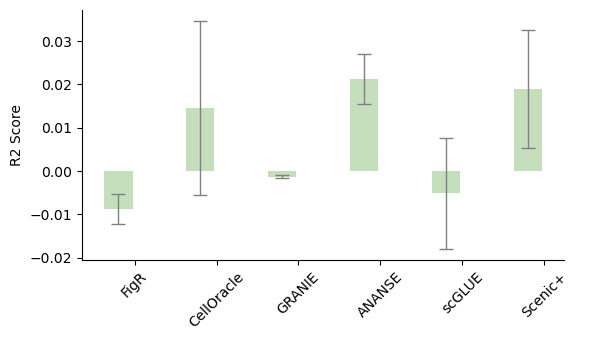

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5)) 

legend_colors = ['#add0a0', '#c4a8b5', 'orange']

offset = .4
width = .35
score_lower_t = -1

handles = []  # To store legend handles
for i_plot, norm_method in enumerate([None]):
    # --- read the scores
    model_names = []
    mean_score_list = []
    scores_all_list = []
    sig_sign_list = []
    # for grn_model in grn_models_dict.keys():
    for grn_model in ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']:
        file = f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/{grn_model}_None.json'
        if not os.path.isfile(file):
            print(f'{file} doesnt exist')
            continue
        with open(file, 'r') as f:
            scores_dict = json.load(f)
            scores_all = np.asarray(list(scores_dict.values()))
            mean_score = np.mean(scores_all) #mean_score_r2
        model_names.append(grn_model)
        mean_score_list.append(mean_score)
        scores_all_list.append(scores_all)
    
    # plot 
    x_ticks = range(len(model_names))
    x_positions = [xx + (offset * (i_plot - 0.5)) for xx in x_ticks]
    error_kw = {'ecolor': 'gray', 'capsize': 5, 'capthick': 1, 'elinewidth': 1}

    y_positions = np.mean(scores_all_list, axis=1) 
    std = np.std(scores_all_list, axis=1)
    # norm_method = surragate_names[norm_method]
    ax.bar(x_positions, height=y_positions, yerr=std, capsize=5, alpha=0.7,  width=width, color=legend_colors[i_plot], error_kw=error_kw, label=norm_method)


    ax.set_xticks(x_ticks)
    ax.set_xticklabels([surragate_names[name] for name in model_names], rotation=45)
    ax.set_ylabel('R2 Score')
    # ax.set_ylim([0, .7])

    #-- annotate 
    # for ii, x_pos in enumerate(x_positions):
    #     y_pos = y_positions[ii] + std[ii] + .2 * i_plot
    #     txt = f'{mean_score_list[ii]:.2f}'
    #     ax.text(x_pos, y_pos, txt, ha='center', color='black', fontsize=8)
ax.legend(loc=(1.01,.8), frameon=False)
# # Correcting text annotations with offset adjustments

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/r2_scores.png', dpi=150, transparent=True)

plt.show()